What's different in this notebook?
- ~~Spacy contextual spellcheck used for correcting context and background~~. Unfortunatel, it doesn't seem to work well.
- Removed stop words and did stemming, lemmatization
- Concatenated wiki_page, background, section_title
- Use only the first question per context

In [ ]:
from boilerplate import *

In [ ]:
dataset = get_data("quac")

Reusing dataset quac (/root/.cache/huggingface/datasets/quac/plain_text/1.1.0/4170258e7e72d7c81bd6441b3f3489ea1544f0ff226ce61e22bb00c6e9d01fb6)


In [ ]:
df = data_to_dataframe(dataset)

In [ ]:
train, simple = df[0], df[2]
df = quac_mediumdf(train)

100%|██████████| 11567/11567 [00:11<00:00, 1032.99it/s]


In [ ]:
df[68:70]

,wiki_page,background,section_title,context,question,answer
68,Hunter S. Thompson,Thompson was born into a middle-class family i...,Fear and Loathing in Las Vegas,The book for which Thompson gained most of his...,What is Fear and Loathing in Las Vegas?,The result of the trip to Las Vegas became the...
69,Hunter S. Thompson,Thompson was born into a middle-class family i...,Fear and Loathing in Las Vegas,The book for which Thompson gained most of his...,Did it do well?,the book was greeted with considerable critica...


Following functon is made so that the dataframe has one context only

In [ ]:
first_ques_df = train
def create_first_ques_df_quac(df):
    data = []
    for i in tqdm(range(len(df))):
        question = df.iloc[i, 6][0]
        answer = df.iloc[i, 10]["texts"][0]
        data.append([df.iloc[i, 1], df.iloc[i, 2], df.iloc[i, 3], df.iloc[i, 4], question, answer])
    df = pd.DataFrame(data, columns=["wiki_page", "background", "section_title", "context", "question", "answer"])
    return df
df = create_first_ques_df_quac(first_ques_df)

100%|██████████| 11567/11567 [00:01<00:00, 6260.71it/s]


In [ ]:
unanswerable = df[df["answer"]=="CANNOTANSWER"]
answerable = df[df["answer"]!="CANNOTANSWER"]
# unanswerable.head()

In [ ]:
len(answerable), len(unanswerable)

(10730, 837)

In [ ]:
df["answer"].value_counts()

CANNOTANSWER                                                                                   837
album                                                                                            7
The whereabouts of McDaniel's Oscar are currently unknown.                                       7
1986                                                                                             6
In 1981, Colter and her husband returned to release a duet album entitled Leather and Lace.      5
                                                                                              ... 
Brown was one of the nation's few liberal big city mayors when he was elected in 1996.           1
marathon                                                                                         1
Seven-year-old Bok was captured by Giemma, a member of the slave hunting militia,                1
her first album and major-label debut. The album, The Spirit Room,                               1
in particu

In [ ]:
medium_df = df

In [ ]:
medium_df["answerable"] = medium_df["answer"].apply(lambda x: 0 if x=="CANNOTANSWER" else 1)

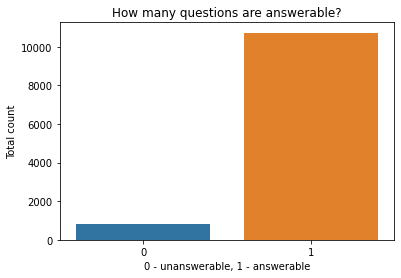

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt = medium_df["answerable"].value_counts()
g0 = sns.barplot(x = cnt.index, y= cnt.values)
g0.set_title("How many questions are answerable?")
g0.set_xlabel("0 - unanswerable, 1 - answerable")
g0.set_ylabel("Total count")
plt.show()

In [ ]:
df["context_length"] = df["context"].apply(lambda input: len(input))
df["answer_length"] = df["answer"].apply(lambda input: len(str(input)))
df["question_length"] = df["question"].apply(lambda input: len(input))
df["background_length"] = df["background"].apply(lambda input: len(input))

In [ ]:
df[:2]

,wiki_page,background,section_title,context,question,answer,answerable,context_length,answer_length,question_length,background_length
0,Malayali,The Malayali people or Keralite people (also s...,Geographic distribution and population,"According to the Indian census of 2001, there ...",Where is Malayali located?,"30,803,747 speakers of Malayalam in Kerala, ma...",1,2036,111,26,580
1,Malayali,The Malayali people or Keralite people (also s...,Language and literature,Malayalam is the language spoken by the Malaya...,what language do they speak?,Malayalam is the language spoken by the Malaya...,1,2850,50,28,580


In [ ]:
# !python install contextualSpellCheck
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
import contextualSpellCheck
nlp = spacy.load("en_core_web_sm")
contextualSpellCheck.add_to_pipe(nlp)
text = nlp("Just typing this to check if the contextua spell check works or not")
print(text._.performed_spellCheck)
text._.outcome_spellCheck


True


'Just typing this to check if the next spell check works or not'

In [ ]:
# Why spacy contextual spellcheck didn't work
text = nlp("Jus a variety of sentences where the spacy contextual spell check is failing")
print(text._.outcome_spellCheck)

and a variety of sentences where the same or spell check is failing


In [ ]:
# Contextual correction of context and background columns
# def typo_correction(text):
#     text = nlp(text)
#     return text
# df["context"] = df["context"].apply(typo_correction)
# df["background"] = df["background"].apply(typo_correction)
# df["question"] = df["question"].apply(typo_correction)

Plotting the frequency of character length in various columns like context, background, questions

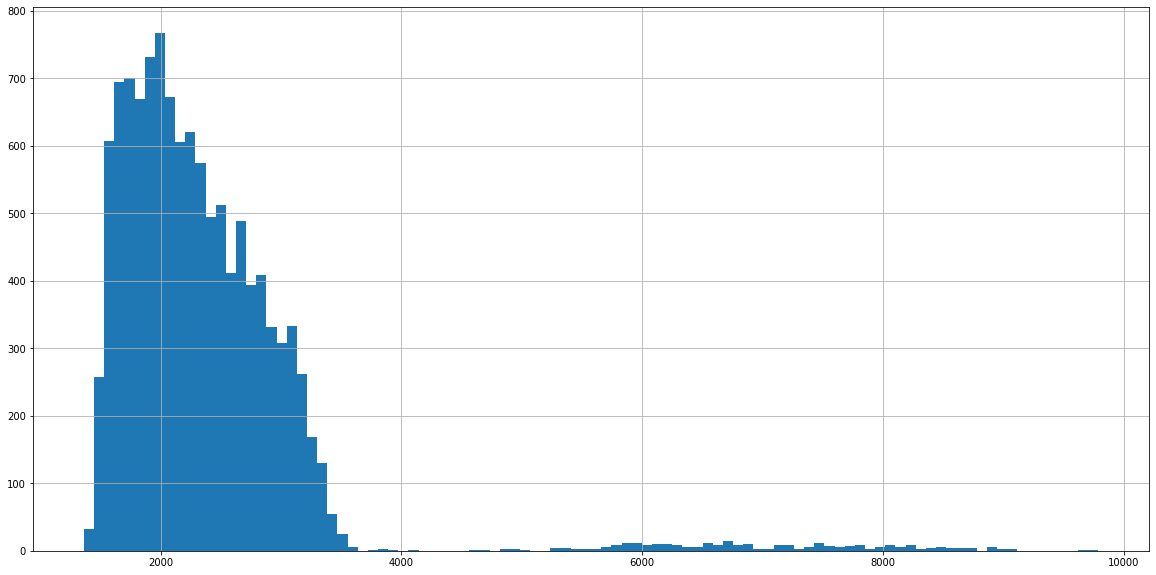

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
df["context_length"].hist(bins = 100)

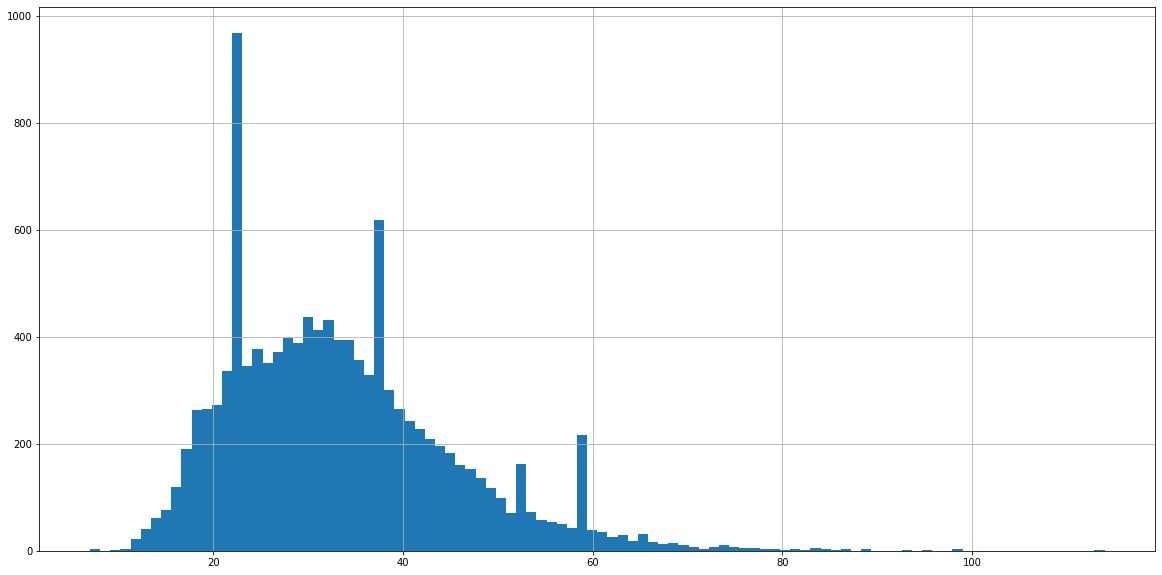

In [ ]:
plt.figure(figsize=(20,10))
df["question_length"].hist(bins = 100)

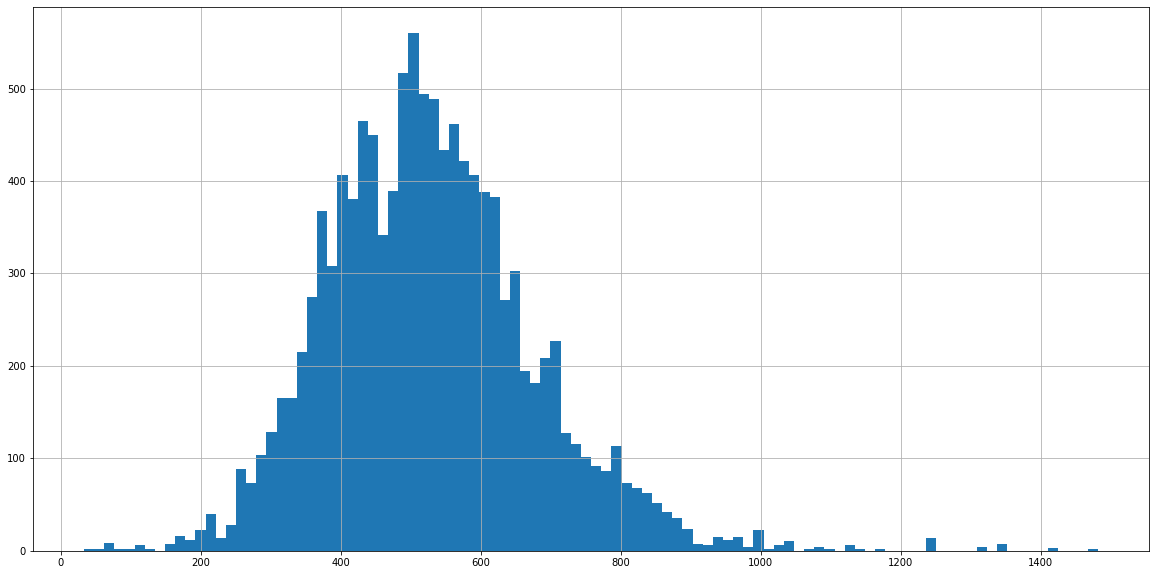

In [ ]:
plt.figure(figsize=(20,10))
df["background_length"].hist(bins = 100)

Creating a plot of highest occuring n-grams

album 15819
band 13216
cannotanswer 11567
new 10839
time 9546
released 9386
later 7803
year 7501
music 7077
film 6242
years 5948
single 5627
song 5553
second 5233
group 5121
tour 4895
world 4849
season 4621
played 4609
record 4588
said 4509
team 4322
number 4274
songs 3900
work 3900
including 3848
did 3801
began 3781
best 3763
early 3758
series 3724
school 3652
won 3650
career 3360
life 3315
american 3306
records 3289
release 3289
called 3277
following 3271


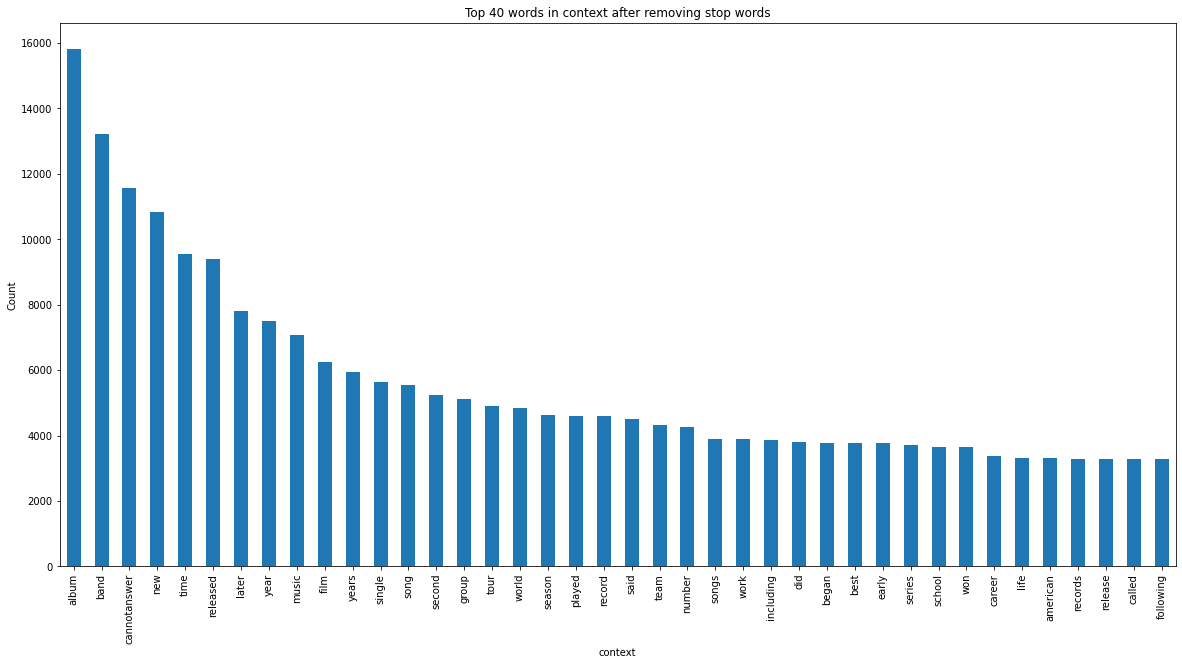

In [ ]:
plt.figure(figsize=(20,10))
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['context'], 40)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['context' , 'count'])
df2.groupby('context').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 40 words in context after removing stop words')

new york 3170
united states 2261
high school 1189
los angeles 1141
studio album 977
york city 745
debut album 675
hot 100 629
music video 592
album released 586
years later 578
billboard 200 568
world war 566
award best 566
hall fame 559
year old 541
following year 534
second album 512
000 copies 496
billboard hot 477
hip hop 457
band released 421
later year 415
san francisco 411
new album 410
million copies 407
rock roll 404
reached number 404
peaked number 400
years old 392
world cup 384
second single 373
band members 371
released single 371
lead single 371
released album 363
solo album 353
singles chart 351
york times 349
albums chart 343


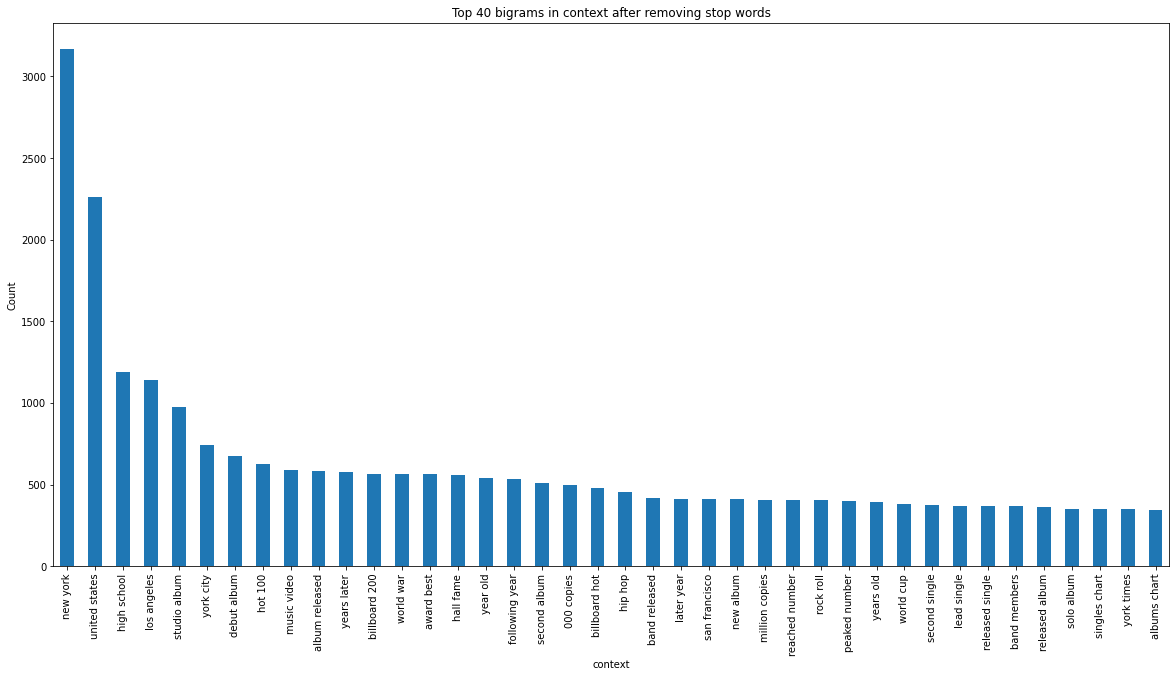

In [ ]:
plt.figure(figsize=(20,10))
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['context'], 40)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['context' , 'count'])
df3.groupby('context').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 40 bigrams in context after removing stop words')

In [ ]:
def question_tagging(question):
    question = question.lower()
    
    if "what" in question:
       return "what"
    elif "when" in question:
        return "when"
    elif "who" in question:
        return "who"
    elif "how" in question:
        return "how"
    elif "which" in question:
        return "which"
    elif "where" in question:
        return "where"
    elif "why" in question:
        return "why"
    elif "did" in question:
        return "did"
    elif "does" in question:
        return "does"
    elif "if" in question:
        return "if"
    elif "else" in question:
        return "else"
    else:
      return "others"

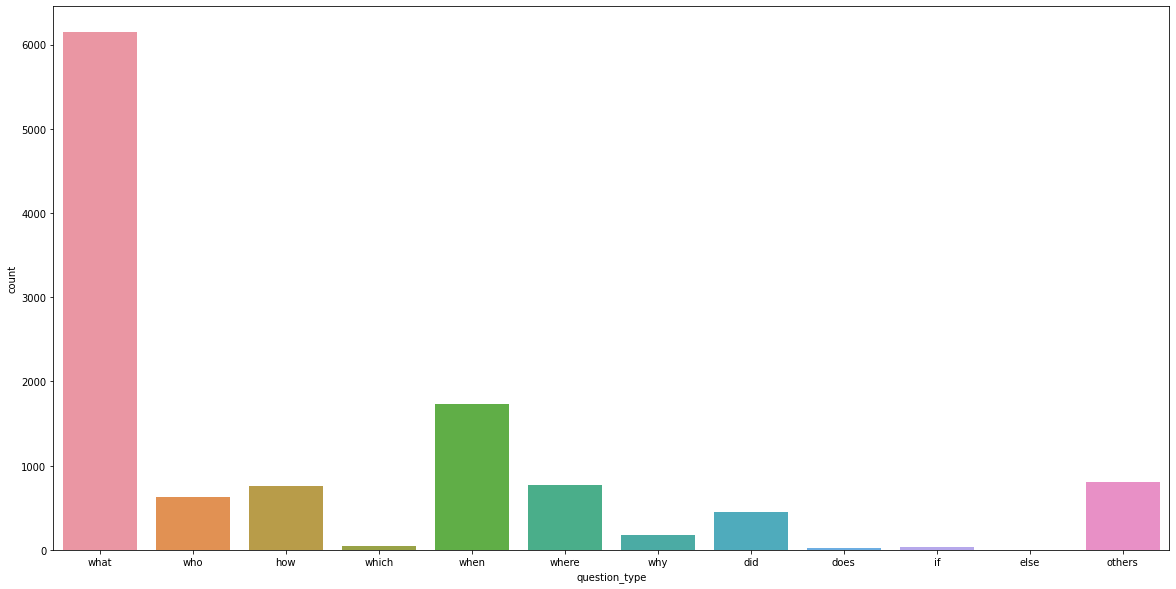

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
df["question_type"] = df["question"].apply(question_tagging)
sns.countplot(x="question_type",data = df, order = ["what","who","how","which", "when","where","why","did", "does", "if", "else", "others"])

In [ ]:
df[df["question_type"] == "others"].head(2)

,wiki_page,background,section_title,context,question,answer,answerable,context_length,answer_length,question_length,background_length,question_type
13,Buddy Hackett,"Hackett was born in Brooklyn, New York to Anna...",Stanley,Hackett starred as the title character on NBC-...,Was Stanley a character he played?,Hackett starred as the title character on NBC-...,1,1714,69,34,274,others
37,The Vicomte of Bragelonne: Ten Years Later,The Vicomte of Bragelonne: Ten Years Later (Fr...,Part Two: Louise de la Valliere (Chapters 94-180),This part mostly concerns romantic events at t...,Was chapter 94 eventful?,This part mostly concerns romantic events at t...,1,2400,68,24,168,others


In [ ]:
!pip3 install bertopic[all] -q

In [ ]:
from bertopic import BERTopic

Stemming and lemmatizing the context and background

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
# nltk.download("wordnet")
nltk.download("punkt")
load_model = spacy.load('en_core_web_sm',disable=["parser","ner"])
sp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def data_preprocess_lemmitize(text):
    # Remove Stop Words
    all_stopwords = sp.Defaults.stop_words
    text_tokens = word_tokenize(text)
    tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
    new_text = ' '.join(tokens_without_sw)
  
    # Spell Check and Correction
    #new_text = sp(new_text)._.outcome_spellCheck
  
    #Perform lemmitization
    doc = load_model(new_text)
    new_text = " ".join([token.lemma_ for token in doc])
  
    return new_text

In [ ]:
def data_preprocess_stem(text):
    # Remove Stop Words
    all_stopwords = sp.Defaults.stop_words
    text_tokens = word_tokenize(text)
    tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
    new_text = ' '.join(tokens_without_sw)
  
    # Spell Check and Correction
    #doc = sp(new_text)
    #new_text = doc._.outcome_spellCheck
    #print(doc._.performed_spellCheck)
  
    #Perform stemming
    ps = PorterStemmer()
    result = []
    for word in word_tokenize(new_text):
      result.append(ps.stem(word))
    new_text = " ".join(result)
  
    return new_text

In [ ]:
from time import time
t = time()
df_clean["context"] = df["context"].apply(data_preprocess_lemmitize)
df_clean["background"] = df["background"].apply(data_preprocess_lemmitize)
df_clean["section_title"] = df["section_title"]
df_clean["wiki_page"] = df["wiki_page"]
df_clean["question"] = df["question"].apply(data_preprocess_lemmitize)
print(f"Time taken for cleaning: {(time() - t)/60} minutes")

In [ ]:
# import re
# from time import time
# import spacy
# nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
# def cleaning(doc):
    # Lemmatizes and removes stopwords
    # txt = [token.lemma_ for token in doc if not token.is_stop]
# context_cleaning = (re.sub("[^A-Za-z']+", " ", str(row)).lower() for row in df["context"])
# bg_cleaning = (re.sub("[^A-Za-z']+", " ", str(row)).lower() for row in df["background"])

In [ ]:
# t = time()
# txt1 = [cleaning(doc) for doc in nlp.pipe(context_cleaning, batch_size=1000)]
# txt2 = [cleaning(doc) for doc in nlp.pipe(bg_cleaning, batch_size=1000)]
# df_clean = pd.DataFrame({"context": txt1, "background": txt2})
# print(f"Time to clean everything: {(time()-t)/60} minutes")

Time to clean everything: 5.356396273771922 minutes


In [ ]:
df_clean[:2]

,context,background,section_title,wiki_page,question
0,"accord indian census 2001 , 30,803,747 speaker...",the Malayali people keralite people ( spelt Ma...,Geographic distribution and population,Malayali,where Malayali locate ?
1,Malayalam language speak Malayalis . Malayalam...,the Malayali people keralite people ( spelt Ma...,Language and literature,Malayali,language speak ?


Concatenating the background, wiki_page, section_title before fitting the bertopic on the context column

In [ ]:
def concatenate_everything(df):
    for i in range(len(df)):
        df.iloc[i,0] = str(df.iloc[i,0]) + " " + str(df.iloc[i, 1])+ " " + df.iloc[i, 2] + " " + df.iloc[i, 3]
    return df
df_clean = concatenate_everything(df_clean)
df_clean[67:70]

,context,background,section_title,wiki_page,question
67,"on January 5 , 1998 , Bono die injury hit tree...","Sonny & Cher american pop music duo , actor , ...","Bono's death, and music copyright",Sonny & Cher,when Bono die ?
68,"an aspire writer obsessive fan , James begin w...","James bear Holton , Kansas ; mother , die 1954...",The Bill James Baseball Abstracts,Bill James,what Baseball abstract ?
69,"in 1953 , New York City , marry JoAnn Schumach...","Murray Newton Rothbard ( ; March 2 , 1926 - Ja...","Marriage, employment, and activism",Murray Rothbard,do marry ?


In [ ]:
unique_contexts = df_clean["context"].unique()

In [ ]:
len(unique_contexts), len(train), len(df)

(6843, 11567, 11567)

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, probabilities = topic_model.fit_transform(unique_contexts)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

2816 documents have not been classified
The other 4027 documents are 79 topics


In [ ]:
topic_freq.head()

,Topic,Count
0,-1,2816
1,0,563
2,1,168
3,2,164
4,3,159


In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 563 documents that are talking about topic ID 0


In [ ]:
for i in range(10):
  topic_no = topic_freq['Topic'].iloc[i]
  print("Topic ", topic_no," : \n")
  print(topic_model.get_topic(topic_no))
  print("\n\n")

Topic  -1  : 

[('band', 0.006847604521437951), ('album', 0.006627786001166691), ('release', 0.006296625551250619), ('song', 0.005832637721533675), ('record', 0.005446143328899945), ('music', 0.005363578829657063), ('group', 0.005093890630010555), ('rock', 0.00475281403624523), ('cannotanswer', 0.0043681347502522215), ('perform', 0.0039154136293142105)]



Topic  0  : 

[('television', 0.009713073932267967), ('comedy', 0.008817276507753513), ('show', 0.008297520169365405), ('character', 0.0081538569668207), ('episode', 0.00793047646370549), ('broadway', 0.006237104710087694), ('actor', 0.0062317285619487755), ('cast', 0.006147693418900621), ('nbc', 0.004863163590085786), ('colbert', 0.004800357198459663)]



Topic  1  : 

[('single', 0.023606768049574907), ('album', 0.016725341298597915), ('song', 0.014362011875708177), ('hot', 0.012967311156461327), ('peak', 0.011670580040815195), ('shelton', 0.00965617183245857), ('music', 0.008610288418908344), ('track', 0.007626665625329416), ('rec

In [ ]:
# Returns how spatially separated each topic is.
topic_model.visualize_topics()

In [ ]:
new_topic = "Buddha"

In [ ]:
# Find_Topic function returns the five most similar topics to the input text in the decreasing order
topic_model.find_topics(new_topic)

([33, 29, 2, 11, 41],
 [0.584072385477862,
  0.5226176759084455,
  0.4970888199122748,
  0.4221634323497815,
  0.40561592312562517])

In [ ]:
topic_model.find_topics(new_topic)[1][0]

0.584072385477862

In [ ]:
#Get_Topic returns the contents of each topic 
topic_model.get_topic(2)

[('theory', 0.012754515376263709),
 ('freud', 0.010104844070118663),
 ('philosophy', 0.009643796563063713),
 ('psychology', 0.009035949904585675),
 ('god', 0.00706204068012038),
 ('idea', 0.006888886711036174),
 ('philosopher', 0.006735035493149166),
 ('believe', 0.006730779210320902),
 ('nature', 0.006407348579323045),
 ('religion', 0.0062281969954573625)]

In [ ]:
# Analysis of the distribution of top similarity measure for each question in the training set (To find out the appropriate threshold)
similarities = []
for question in df_clean["question"].values:
    similarities.append(topic_model.find_topics(question)[1][0])

Text(0.5, 1.0, 'Distriution of top similarity measures of each question')

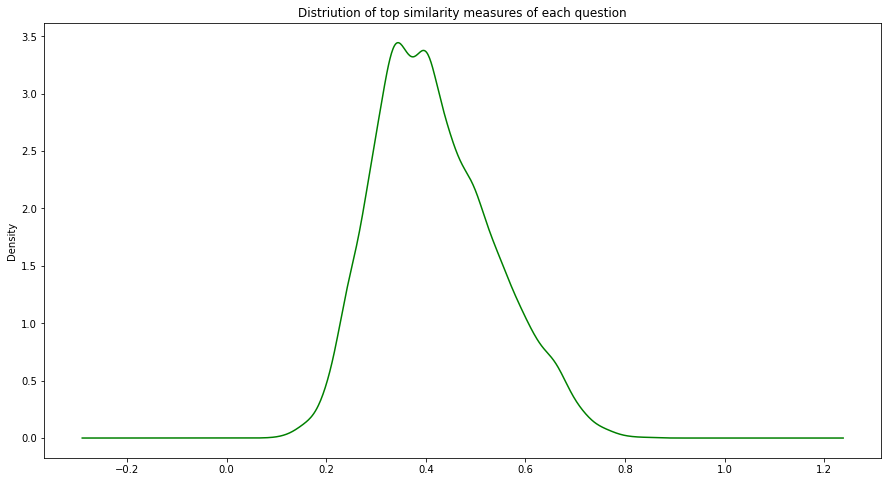

In [ ]:
plt.figure(figsize=(15,8))
distribution = pd.DataFrame(similarities,columns=['similarity'])
distribution.similarity.plot.density(color="green")
plt.title("Distriution of top similarity measures of each question")

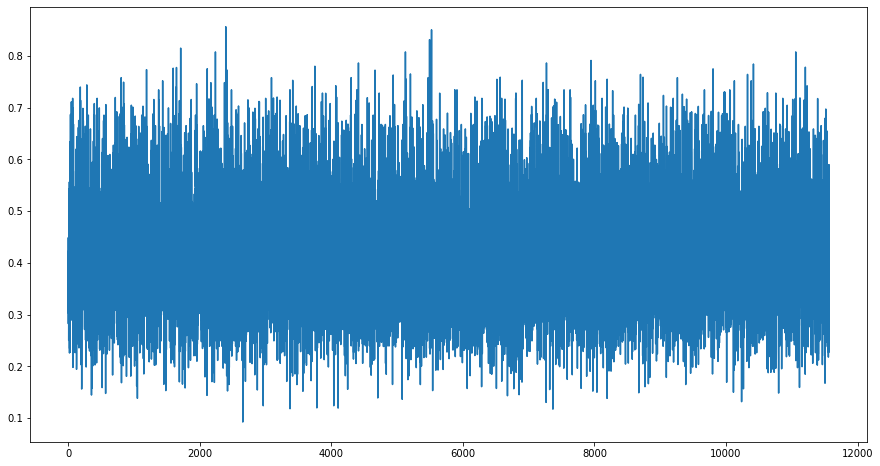

In [ ]:
plt.figure(figsize=(15,8))
distribution.similarity.plot()

In [ ]:
# Maximim similarity value for a question
print(max(similarities))
# Least similarity value for a question
print(min(similarities))
# Mean similarity value for a question
print(sum(similarities)/len(similarities))

0.856197931931736
0.09219891998605081
0.4170226690047247


We vary the threshold in the follwing cell to check how many rows are being dropped for that particular threshold

In [ ]:
c = 0
for i in range(len(train)):
    if similarities[i] >= 0.34:
        c += 1
    else:
        if i<20:
            print(i)
print("\nCount dropped: ",len(train) - c)

2
4
5
9
12
14
15
16
17

Count dropped:  3335


In [ ]:
# Example of a dropped question
df_clean.iloc[16,1]

"Lester Willis Young ( August 27 , 1909 - March 15 , 1959 ) , nickname ` ` Pres '' ` ` Prez '' , american jazz tenor saxophonist occasional clarinetist . come prominence member Count Basie orchestra , young influential player instrument . in contrast hard - drive peer , Young play relaxed , cool tone sophisticated harmony , critic call ` ` free - float style , wheel diving like gull , banking low , funky riff please dancer listener alike '' . know hip , introverted style , invent popularize hipster jargon come associate music ."

In [ ]:
df_clean.iloc[16, 4]

'when join ?'

In [ ]:
# Heatmap on the correlation between each of the clustered topics
plt.figure(figsize=(200,200))
topic_model.visualize_heatmap()

<Figure size 14400x14400 with 0 Axes>

In [ ]:
# Agglomerative Clustering on the topics clustered based on unique contexts
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_params()


{'calculate_probabilities': True,
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7fd89c5bca50>,
 'hdbscan_model': HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
         approx_min_span_tree=True, cluster_selection_epsilon=0.0,
         cluster_selection_method='eom', core_dist_n_jobs=4,
         gen_min_span_tree=False, leaf_size=40,
         match_reference_implementation=False, memory=Memory(location=None),
         metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
         prediction_data=True),
 'language': 'english',
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': None,
 'top_n_words': 10,
 'umap_model': UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
      dens_var_shift=0.1, densmap=False, disconnection_distance=None,
      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
      local_connectivity=1.0, low_memory

In [ ]:
# topic_model.save("./topic_model")

In [ ]:
def topic_filterizer(question):
  if topic_model.find_topics(question)[1][0] >= 0.5:
    return True
  else:
    return False

new_train = df[df["question"].apply(topic_filterizer) == True].head()

In [ ]:
df[df["question"].apply(topic_filterizer) == True]

,wiki_page,background,section_title,context,question,answer,answerable,context_length,answer_length,question_length,background_length,question_type
24,Aesop Rock,"Ian Matthias Bavitz (born June 5, 1976), bette...","2005-2007: Fast Cars EP, None Shall Pass, Nike...","In February 2005, Aesop Rock released a new EP...",When was Fast Cars released?,"In February 2005,",1,2100,17,28,459,when
34,Therapy?,Therapy? are an alternative metal band from No...,The success (1993-1995),"If there was one true ""breakthrough"" year in t...",Did they release any albums in 1993?,The release of the Shortsharpshock EP catapult...,1,1851,56,36,360,did
36,Ben Carson,Benjamin Solomon Carson Sr. (born September 18...,High school,"By ninth grade, the family's financial situati...",Where did Carson attend high school,Southwestern High School,1,2413,24,35,547,where
49,Andrés Galarraga,Andres Jose Padovani Galarraga (Spanish: [an'd...,National League batting champion (1993),"By joining the Rockies, he was given new life ...",when did he become national league batting cha...,He led National League batters in batting aver...,1,2943,146,52,561,when
50,Andrés Galarraga,Andres Jose Padovani Galarraga (Spanish: [an'd...,Atlanta Braves (1998-2000),"During his first season in Atlanta in 1998, Ga...",What position did he play with the Braves?,CANNOTANSWER,0,1878,12,42,561,what
...,...,...,...,...,...,...,...,...,...,...,...,...
11526,Stephen Hillenburg,"Stephen McDannell Hillenburg (born August 21, ...",Personal life,"Hillenburg's wife, Karen, is a chef who teache...",Does he have children?,He would jam with his son who is a drummer whi...,1,1961,116,22,583,does
11529,Styx (band),Styx is an American rock band from Chicago th...,Solo careers,Dennis DeYoung and Tommy Shaw released a strin...,Was the band successful with their solo careers?,Both Shaw and DeYoung generated a moderate amo...,1,2396,91,48,543,others
11530,Memoirs of a Geisha (film),Memoirs of a Geisha is a 2005 American epic dr...,Chinese responses,The film received some hostile responses in Ma...,How did China respond to the film?,The film received some hostile responses in Ma...,1,1889,59,34,655,how
11534,"Frederick II, Holy Roman Emperor",Frederick II (26 December 1194 - 13 December 1...,Evaluation,Historians rate Frederick II as a highly signi...,where was he a monarch of,European,1,2406,8,25,427,where


In [ ]:
c = 0
for i in range(300):
  if topic_model.find_topics(unanswerable.iloc[i,1])[1][0] >= 0.3:
    c += 1
  else:
    # print(i)
    pass
print("Count: ",c)

Count:  280


In [ ]:
df[:1]

,wiki_page,background,section_title,context,question,answer,answerable,context_length,answer_length,question_length,background_length,question_type
0,Malayali,The Malayali people or Keralite people (also s...,Geographic distribution and population,"According to the Indian census of 2001, there ...",Where is Malayali located?,"30,803,747 speakers of Malayalam in Kerala, ma...",1,2036,111,26,580,where


###### Checking if a question returned as not related to any context (since similarity < threshold) is actually an ambiguous question


In [ ]:
# Similarity of the topic most similar to that question
topic_model.find_topics(unanswerable.iloc[75,4])

([70, 42, 38, 9, 56],
 [0.378092163853305,
  0.23614543353224543,
  0.23287028565890944,
  0.23075956439646783,
  0.21636676911907543])

In [ ]:
topic_model.find_topics(unanswerable.iloc[75,3])

([2, 62, 57, 18, 27],
 [0.2913337489394302,
  0.2816552421735782,
  0.278961363832444,
  0.2607984936647449,
  0.2279509116720838])

In [ ]:
topic_model.find_topics(unanswerable.iloc[75,2])

([72, 48, 62, 16, 32],
 [0.4291322502413048,
  0.3101993848756571,
  0.27896306004734095,
  0.2482211432546808,
  0.24675568634151163])

In [ ]:
# Question under analysis
unanswerable.iloc[75,4]

'did she ever receive backlash'

In [ ]:
# Answer to that question
unanswerable.iloc[75,5]

'CANNOTANSWER'

Now, doing it for answerable ques

In [ ]:
# Similarity of the topic most similar to that question
topic_model.find_topics(answerable.iloc[75,4])

([15, 67, 31, 5, 14],
 [0.4421538694576965,
  0.4328267139975613,
  0.4301794714424208,
  0.41805322736294814,
  0.4142775276227654])

In [ ]:
topic_model.find_topics(answerable.iloc[75,3])

([15, 50, 71, 59, 69],
 [0.533416522681444,
  0.284968567340785,
  0.27718542506730814,
  0.25983402849656057,
  0.2559404607707897])

In [ ]:
topic_model.find_topics(answerable.iloc[75,2])

([15, 67, 52, 50, 5],
 [0.4119748486113536,
  0.3863769415224782,
  0.36813002222793545,
  0.3283669607276488,
  0.32561387863551755])

In [ ]:
# Question under analysis
answerable.iloc[75,4]

'When did he get his first championship?'

In [ ]:
# Answer to that question
answerable.iloc[75,5]

'In November 2004,'